# 2D variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [4]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69958, 36588)

### Setup memento

In [8]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [9]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [11]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

### Compute correlations for STAT1

In [11]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df


In [12]:
beta_df = get_2d_moments('STAT1', ['ciliated'], 'beta')
alpha_df = get_2d_moments('STAT1', ['ciliated'], 'alpha')
gamma_df = get_2d_moments('STAT1', ['ciliated'], 'gamma')
lambda_df = get_2d_moments('STAT1', ['ciliated'], 'lambda')

beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'
df = pd.concat([alpha_df, beta_df])

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg/memento/main.py:539: RuntimeWarning: invalid value encountered in true_divide
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(-0.75, 1)

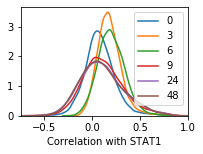

In [23]:
plt.figure(figsize=(3, 2))
for tp in ['0', '3', '6', '9', '24', '48']:#['0', '3', '6', '9', '24', '48']:
    sns.distplot(beta_df['time_' + tp], hist=False, label=tp)
# plt.legend(, frameon=False)
plt.xlabel('Correlation with STAT1')
plt.xlim(-0.75, 1)

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


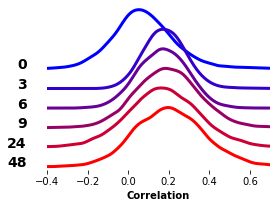

In [21]:
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(6,1)
fig = plt.figure(figsize=(4,3))

i = 0

ax_objs = []
for i, tp in enumerate(['0', '3', '6', '9', '24', '48']):
    x = lambda_df['time_' + tp].values
    x = x[np.isfinite(x)]
    x_d = np.linspace(-0.7,1, 1000)

    kde = KernelDensity(bandwidth=0.025, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),lw=3, color=colors[i])
#     ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.4,0.7)
#     ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == 6-1:
        ax_objs[-1].set_xlabel("Correlation", fontsize=10,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_xticks([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
#     
    ax_objs[-1].set_yticks([])
#     adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.5,0,tp,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.7)

# fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

plt.tight_layout()
plt.show()

### Look for STAT1 DC genes

In [12]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [13]:
import os

In [14]:
done_files = os.listdir('/data_volume/ifn_hbec/tf_test/')

In [14]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3']
stims = ['beta']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
            if fname in done_files:
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
            gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

### What are the STAT1 DC genes?

In [104]:
stim = 'beta'
tp = '3'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

In [105]:

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

moments = memento.get_2d_moments(adata_result, groupby='time')
res_df = memento.get_2d_ht_result(adata_result)
# rel_res_df = memento.get_2d_ht_result(adata_stim)

In [106]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_3,time_0
324,STAT1,HLA-F,0.516336,0.303196
325,STAT1,HLA-A,0.435438,0.184255
326,STAT1,HLA-E,0.626379,0.415575
327,STAT1,HLA-C,0.530611,0.319793
328,STAT1,HLA-B,0.437998,0.201227


In [80]:
wired_pairs = moments.query('time_0 > 0.25 | time_{} > 0.25'.format(tp))

In [81]:
filtered_res_df = df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [ ]:
for g in filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0').gene_2.tolist():
    print(g)

In [52]:
filtered_res_df.shape

(869, 7)

In [53]:
res_df.shape

(891, 5)

### Re-run the STAT1 anaylsis for subset

In [15]:
tf = 'STAT1'

cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
#             if fname in done_files:
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            
            gene_list = adata_stim.var.index.tolist()
            
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
#             gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

#             memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

#             memento.ht_2d_moments( 
#                 adata_stim, 
#                 formula_like='1 + time_step',
#                 cov_column='time_step', 
#                 num_boot=10000, 
#                 verbose=1,
#                 num_cpus=13)

#             if 'mv_regressor' in adata_stim.uns['memento']:
#                 del adata_stim.uns['memento']['mv_regressor']
#             adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

starting ['ciliated'] 3 alpha
starting ['ciliated'] 3 beta
starting ['ciliated'] 3 gamma


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide


starting ['ciliated'] 3 lambda
starting ['ciliated'] 6 alpha
starting ['ciliated'] 6 beta
starting ['ciliated'] 6 gamma
starting ['ciliated'] 6 lambda
starting ['ciliated'] 9 alpha
starting ['ciliated'] 9 beta
starting ['ciliated'] 9 gamma
starting ['ciliated'] 9 lambda
starting ['ciliated'] 24 alpha
starting ['ciliated'] 24 beta
starting ['ciliated'] 24 gamma
starting ['ciliated'] 24 lambda
starting ['ciliated'] 48 alpha
starting ['ciliated'] 48 beta
starting ['ciliated'] 48 gamma
starting ['ciliated'] 48 lambda


### Compile STAT1 DC and correlation status

In [16]:
stim = 'gamma'
ct = ['ciliated']
tf = 'STAT1'

In [17]:

for tp in ['3', '6', '9', '24', '48']:
    
    print(tp)

    fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
    adata_result = sc.read(fname)
    
#     moments = memento.get_2d_moments(adata_result, groupby='time_step').rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    moments = pd.read_csv('/data_volume/ifn_hbec/tf_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf)).rename(columns={'time_step_0':'time_0', 'time_step_1':'time_'+tp})
    res_df = memento.get_2d_ht_result(adata_result)\
        .rename(columns={
            'corr_coef':'corr_coef' + '_' + tp,
            'corr_pval':'corr_pval' + '_' + tp})
    
    if tp == '3':

        pv_df = res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy()
        coef_df = res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy()
        moment_df = moments[['gene_1', 'gene_2', 'time_0', 'time_3']].copy()
        
    else:
        
        pv_df = pv_df.merge(res_df[['gene_1', 'gene_2', 'corr_pval' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        coef_df = coef_df.merge(res_df[['gene_1', 'gene_2', 'corr_coef' + '_' + tp]].copy(), on=['gene_1', 'gene_2'], how='outer')
        moment_df = moment_df.merge(moments[['gene_1', 'gene_2', 'time_{}'.format(tp)]].copy(), on=['gene_1', 'gene_2'], how='outer')
    
    
    

3
6
9
24
48


In [18]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3094,STAT1,HLA-A,0.172667,0.264742,0.196805,0.136728,0.101051,0.097405
3115,STAT1,HLA-C,0.314121,0.397101,0.337141,0.287205,0.147436,0.177297
3116,STAT1,HLA-B,0.196586,0.293571,0.286509,0.216158,0.123979,0.082816
6658,STAT1,B2M,0.177316,0.238690,0.196549,0.146857,0.054398,0.054794


### Check 2D moments over time

In [20]:
isg_genes = ['ISG15', 'MX1', 'MX2', 'ISG15', 'OAS1', 'OAS2', 'OAS3', 'OASL',]

In [21]:
moment_df.query('gene_2.isin(@isg_genes)', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3,STAT1,ISG15,0.713398,0.472722,0.484757,0.494712,0.440472,0.503382
5996,STAT1,OAS1,0.646565,0.498528,0.492114,0.598161,0.472078,0.535351
5997,STAT1,OAS3,0.732475,0.525359,0.516637,0.595635,0.591296,0.635312
5998,STAT1,OAS2,0.899163,0.645379,0.618742,0.618230,0.649674,0.663459
6029,STAT1,OASL,0.549513,0.273677,0.252218,0.320974,0.270424,0.478260
8913,STAT1,MX2,0.791370,0.446193,0.431638,0.504710,0.398981,0.529850
8914,STAT1,MX1,0.823748,0.473797,0.495038,0.559051,0.494222,0.590052


In [139]:
moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,time_0,time_3,time_6,time_9,time_24,time_48
3097,STAT1,HLA-A,0.184255,0.275632,0.204322,0.135832,0.103195,0.100389
3118,STAT1,HLA-C,0.319793,0.405229,0.340785,0.283306,0.145822,0.176469
3119,STAT1,HLA-B,0.201227,0.302763,0.290189,0.211899,0.122095,0.082566
6662,STAT1,B2M,0.184621,0.249761,0.203064,0.147616,0.055379,0.055576


In [117]:
coef_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_coef_3,corr_coef_6,corr_coef_9,corr_coef_24,corr_coef_48
325,STAT1,HLA-A,0.404269,0.387095,NaN,NaN,NaN
327,STAT1,HLA-C,0.273931,0.351479,0.211282,0.15942,NaN
328,STAT1,HLA-B,0.381630,0.406874,NaN,NaN,NaN
649,STAT1,B2M,0.291344,0.413924,NaN,NaN,NaN


In [140]:
pv_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene_1,gene_2,corr_pval_3,corr_pval_6,corr_pval_9,corr_pval_24,corr_pval_48
216,STAT1,HLA-C,0.072993,NaN,NaN,NaN,NaN


In [146]:
vals = moment_df.query('gene_2.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 2:]
vals = moment_df.query('gene_2.isin(@isg_genes)', engine='python').values[:, 2:]

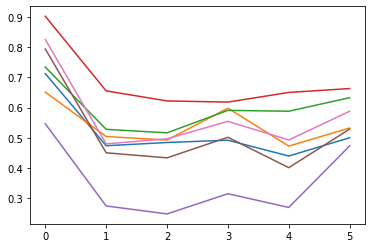

In [147]:
plt.plot(vals.T)

### Check some expresssion level over time

In [143]:
stim = 'gamma'
ct = ['ciliated']

In [144]:
subset = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()
memento.create_groups(subset, label_columns=['time', 'donor'])
memento.compute_1d_moments(subset, min_perc_group=.80)
print('NLRC5' in subset.var.index.tolist())
mean_df = memento.get_1d_moments(subset, groupby='time')[0][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]
var_df = memento.get_1d_moments(subset, groupby='time')[1][['gene'] + ['time_' + str(i) for i in [0, 3, 6, 9, 24, 48]]]

True


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:529: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [145]:
df.query('gene == "ISG15"')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
4,ISG15,1.825076,4.087663,4.429946,4.485706,4.285943,4.023297


In [123]:
isg_genes = ['ISG15', 'MX1', 'MX2', 'ISG15', 'OAS1', 'OAS2', 'OAS3', 'OASL',]

In [124]:
isg_mat = df.query('gene.isin(@isg_genes)', engine='python').values[:, 1:]

c1_mat = df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:]
# c1_mat = c1_mat/c1_mat[:, 0].reshape(-1,1)

In [126]:
mean_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3342,HLA-A,1.656812,2.370405,2.487690,2.090583,2.035615,1.793220
3367,HLA-C,1.829254,2.479059,2.770877,2.521157,2.434578,2.142253
3368,HLA-B,1.967847,2.673597,2.807899,2.552474,2.472788,2.166302
7264,B2M,4.189476,4.438093,4.546697,4.348129,4.342992,4.125379


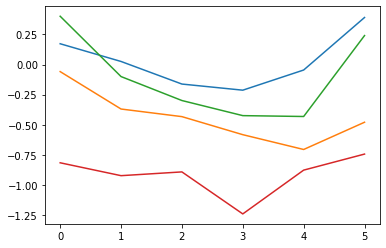

In [130]:
plt.plot(var_df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python').values[:, 1:].T)

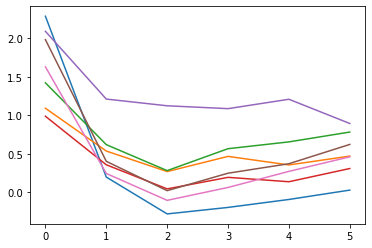

In [133]:
plt.plot(var_df.query('gene.isin(@isg_genes)', engine='python').values[:, 1:].T)

In [60]:
beta_stim = adata[adata.obs['cell_type'].isin(ct) & adata.obs.stim.isin(['control', stim])].copy().copy()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([array([698.,   0.,   0.,  37.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.]),
  array([757.,   0.,   0., 199.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,
           8.,   0.,   0.,   2.])],
 array([0.        , 0.26666668, 0.53333336, 0.8       , 1.0666667 ,
        1.3333334 , 1.6       , 1.8666667 , 2.1333334 , 2.4       ,
        2.6666667 , 2.9333334 , 3.2       , 3.4666667 , 3.7333333 ,
        4.        ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

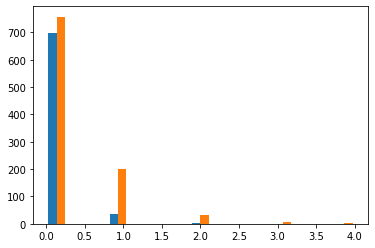

In [61]:
plt.hist([
    beta_stim[beta_stim.obs.time == '0', :][:, 'NLRC5'].X.todense().A1, 
    beta_stim[beta_stim.obs.time == '3', :][:, 'NLRC5'].X.todense().A1],
    bins=15)
# plt.hist(adata[adata.obs.time == '3', :][:, 'NLRC5'].X.todense().A1, bins=15)

In [62]:
df.query('gene.isin(["NLRC5"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
7798,NLRC5,-2.844202,-1.290465,-0.997472,-0.961713,-0.956975,-0.941885


In [63]:
df.query('gene.isin(["HLA-A", "HLA-B", "HLA-C", "B2M"])', engine='python')

,gene,time_0,time_3,time_6,time_9,time_24,time_48
3342,HLA-A,1.656812,2.370405,2.487690,2.090583,2.035615,1.793220
3367,HLA-C,1.829254,2.479059,2.770877,2.521157,2.434578,2.142253
3368,HLA-B,1.967847,2.673597,2.807899,2.552474,2.472788,2.166302
7264,B2M,4.189476,4.438093,4.546697,4.348129,4.342992,4.125379
